<a href="https://colab.research.google.com/github/KendallScott/QTW/blob/main/Case%20Study%207/CaseStudy7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
!pip install scikit-learn-intelex


In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from sklearnex import patch_sklearn
#patch_sklearn()
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold, GridSearchCV

from sklearn.utils import shuffle
from numpy import random
from itertools import product

from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, classification_report
from sklearn.pipeline import Pipeline

import xgboost as xgb
from xgboost import DMatrix

In [ ]:
from google.colab import drive
drive.mount('drive')

In [ ]:
df = pd.read_csv("drive/My Drive/final_project(5).csv")

In [ ]:
df.info()
#there are NAs will need handling

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Data columns (total 51 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   x0      159974 non-null  float64
 1   x1      159975 non-null  float64
 2   x2      159962 non-null  float64
 3   x3      159963 non-null  float64
 4   x4      159974 non-null  float64
 5   x5      159963 non-null  float64
 6   x6      159974 non-null  float64
 7   x7      159973 non-null  float64
 8   x8      159979 non-null  float64
 9   x9      159970 non-null  float64
 10  x10     159957 non-null  float64
 11  x11     159970 non-null  float64
 12  x12     159964 non-null  float64
 13  x13     159969 non-null  float64
 14  x14     159966 non-null  float64
 15  x15     159965 non-null  float64
 16  x16     159974 non-null  float64
 17  x17     159973 non-null  float64
 18  x18     159960 non-null  float64
 19  x19     159965 non-null  float64
 20  x20     159962 non-null  float64
 21  x21     15

In [ ]:
for i in df.columns:
    if df[i].isna().sum() > 0:
        print('{} has {}% NAs'.format(i,(df[i].isna().sum() / len(df))*100))

In [ ]:
df['x24'].value_counts()

asia       138965
euorpe      16538
america      4469
Name: x24, dtype: int64

<BarContainer object of 3 artists>

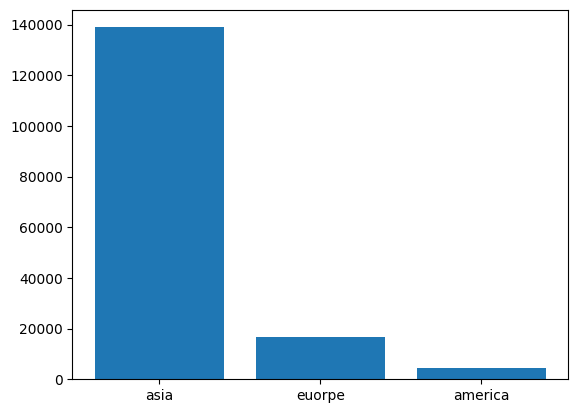

In [ ]:
plt.bar(x=df['x24'].value_counts().index,height=df['x24'].value_counts().values)

In [ ]:
df['x29'].value_counts()

July       45569
Jun        41329
Aug        29406
May        21939
sept.      10819
Apr         6761
Oct         2407
Mar         1231
Nov          337
Feb          140
Dev           23
January        9
Name: x29, dtype: int64

In [ ]:
#clean up month formatting to standard 3 letters
df['x29'].replace(to_replace=['July','sept.','Dev','January'],value=['Jul','Sep','Dec','Jan'],inplace=True)

In [ ]:
mo = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
heights = []
for i in mo:
    x = df['x29'].to_list().count(i)
    heights.append(x)
plt.bar(x=mo,height=heights)

In [ ]:
df['x30'].value_counts()

In [ ]:
# thursday is incorrect
df['x30'].replace(to_replace = 'thurday',value='thursday')
days = ['monday','tuesday','wednesday','thursday','friday']
d_heights = []
for i in days:
    x = df['x30'].to_list().count(i)
    d_heights.append(x)
plt.bar(x=days,height = d_heights)

In [ ]:
df['x32'].value_counts()

In [ ]:
df['x37'].value_counts()


In [ ]:
### x32 and x37 are actually numeric with string format (even though x32 has few "levels" or possible values)
### x32 is in percentage, but don't think it needs to be transformed to proportion since data will be scaled later (will double check, but should make no difference)

df['x32'] = df['x32'].transform(lambda x: float(str(x).replace('%','')))
df['x37'] = df['x37'].transform(lambda x: float(str(x).replace('$','')))

In [ ]:
#all significanlty less than 5%, should be no issue imputing,
#imputing categorical features with modes
# imputing continent with mode, then dates by mode grouped by continent

print('imputing continent with mode: {}'.format(df['x24'].aggregate(pd.Series.mode)))
df['x24'] = df['x24'].transform(lambda x: x.fillna(pd.Series.mode(x)[0]))

print('imputing month with mode by cont: {}'.format(df[['x24','x29']].groupby(by='x24').aggregate(pd.Series.mode)))
idx_29 = df.loc[df['x29'].isna(),:].index #saving NAs indices to quick check what they've been imputed with
df['x29'] = df[['x24','x29']].groupby(by='x24').transform(lambda grp: grp.fillna(pd.Series.mode(grp)[0]))

# will fix index showing on print later


In [ ]:
df[['x24','x29','x30']].groupby(by=['x24','x29']).aggregate(pd.Series.mode)
# could just impute with wednesday since Wed is mode per month, but adding continent gives more context and different days for some months

In [ ]:
# impute day
df['x30'] = df[['x24','x29','x30']].groupby(by=['x24','x29']).transform(lambda grp: grp.fillna(pd.Series.mode(grp)[0]))

In [ ]:
X = df.loc[:,df.columns != 'y']
y = df['y'].values.flatten()

df_num = X.select_dtypes(exclude='object')
num_cols = df_num.columns

# impute numeric with median
for i in num_cols:
    df_num[i] = df_num[i].transform(lambda x: x.fillna(pd.Series.mode(x)[0]))
df_num.info()

df_cat = X.select_dtypes(include='object')
cat_cols = df_cat.columns

# scale numerical data
scaler = StandardScaler()
df_num = scaler.fit_transform(df_num)

#one hot encode cat data
encoder = OneHotEncoder(sparse_output=False)
df_cat = encoder.fit_transform(df_cat)

In [ ]:
X = np.hstack([df_num,df_cat])

In [ ]:
df['y'].value_counts() # not balanced

In [ ]:
#add y plot

In [ ]:
skf = StratifiedKFold(n_splits=5,random_state=807,shuffle=True)
skf.get_n_splits(X,y)

In [ ]:
from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
rf = RandomForestClassifier(random_state=624,n_jobs=-1,n_estimators=50,criterion='gini', class_weight='balanced')

In [ ]:
from numpy import random
from itertools import product
from sklearn.utils import shuffle

In [ ]:
#setting up a hyperparameter dataframe

learning_rates = [0.15, 0.25, 0.35]
max_depths = [3, 5, 10, 20]
gamma = [0,1,3]
lambda_ls = [1,2,3]
alpha = [0,0.1,1]

xgb_param = pd.DataFrame(list(product(learning_rates, max_depths, gamma, lambda_ls, alpha)), columns=['learning_rate', 'max_depth', 'gamma', 'lambda', 'alpha'])

#randomizing the dataframe order
xgb_param = shuffle(xgb_param)
xgb_param = xgb_param.reset_index()
xgb_param=xgb_param.drop(['index'], axis=1)
xgb_param

,learning_rate,max_depth,gamma,lambda,alpha
0,0.25,10,0,1,0.0
1,0.10,20,0,1,0.1
2,0.10,5,1,3,1.0
3,0.10,3,3,1,0.1
4,0.10,20,3,3,0.0
...,...,...,...,...,...
211,0.25,3,0,1,0.1
212,0.25,3,0,2,1.0
213,0.10,3,0,3,0.0
214,0.10,10,1,2,1.0


In [73]:
dtrain = xgb.DMatrix(X, label=y, enable_categorical=True)

trials = 20
best_params = {}
i=0

for i in range(trials):
  #random sampling from paramdf
  hyperparams = {'objective': 'binary:logistic', 'eta': xgb_param['learning_rate'][i], 'max_depth': xgb_param['max_depth'][i], 'gamma': xgb_param['gamma'][i], 'lambda': xgb_param['lambda'][i], 'alpha': xgb_param['alpha'][i]}

  print(hyperparams)
  out=xgb.cv(params=hyperparams,  num_boost_round=50, dtrain=dtrain, nfold=5, stratified=True, early_stopping_rounds=5, verbose_eval=1)
  index=out.shape[0]-1
  result=out.iloc[index,2]
  if i< 1:
    best_result = result
    best_params = hyperparams

  if result< best_result:
      best_result = result
      best_params = hyperparams
      print('result: ' ,result)
      print('best result: ' ,best_result)
      print('hyperparameters: ' ,hyperparams)
      print('best hyperparameters: ' ,best_params)
      i+=1

{'objective': 'binary:logistic', 'eta': 0.35, 'max_depth': 10, 'gamma': 3, 'lambda': 3, 'alpha': 0.1}
[0]	train-logloss:0.52347+0.00089	test-logloss:0.53287+0.00086
[1]	train-logloss:0.42200+0.00135	test-logloss:0.43823+0.00250
[2]	train-logloss:0.35605+0.00217	test-logloss:0.37741+0.00232
[3]	train-logloss:0.30864+0.00196	test-logloss:0.33444+0.00283
[4]	train-logloss:0.27521+0.00165	test-logloss:0.30450+0.00181
[5]	train-logloss:0.24832+0.00328	test-logloss:0.28089+0.00287
[6]	train-logloss:0.22842+0.00348	test-logloss:0.26298+0.00365
[7]	train-logloss:0.21206+0.00317	test-logloss:0.24917+0.00228
[8]	train-logloss:0.19956+0.00379	test-logloss:0.23854+0.00386
[9]	train-logloss:0.18974+0.00295	test-logloss:0.22977+0.00396
[10]	train-logloss:0.17923+0.00452	test-logloss:0.22109+0.00385
[11]	train-logloss:0.17094+0.00368	test-logloss:0.21419+0.00321
[12]	train-logloss:0.16597+0.00380	test-logloss:0.20978+0.00274
[13]	train-logloss:0.16018+0.00238	test-logloss:0.20511+0.00277
[14]	train-l

KeyboardInterrupt: ignored

In [ ]:
best_params

In [ ]:
hyperparams = { 'eta':0.1, 'max_depth': 20, 'gamma': 3, 'lambda': 3, 'alpha': 1.0, 'objective': 'binary:logistic'}

XGBModel = xgb.XGBClassifier(params=hyperparams, num_boost_round=200, dtrain=dtrain, nfold=5, stratified=True, early_stopping_rounds=5, verbose_eval=1)

In [ ]:
skf_results = skf(XGBModel,X,y,scoring = ['roc_auc','accuracy','precision','recall'])
skf_results

In [ ]:
#setting up a hyperparameter dataframe for RF
min_samples_leaf = [3,4,5]
max_features = ['sqrt',7,10,'log2',None]
min_samples_split = [2,4,8]

rf_param = pd.DataFrame(list(product(min_samples_leaf, max_features, min_samples_split)), columns=['min_samples_leaf', 'max_features', 'min_samples_split'])

#randomizing the dataframe order
rf_param = shuffle(rf_param)
rf_param = rf_param.reset_index()
rf_param=rf_param.drop(['index'], axis=1)
rf_param

In [ ]:
trials = 20
best_params = {}
i=0

for i in range(trials):
  #random sampling from paramdf

  hyperparams = {'objective': 'binary:logistic', 'min_samples_leaf': rf_param['min_samples_leaf'][i], 'max_features': rf_param['max_features'][i], 'min_samples_split': rf_param['min_samples_split'][i]}
  print(hyperparams)

  rf = RandomForestClassifier(random_state=624,n_jobs=-1,n_estimators=50,criterion='entropy', class_weight='balanced')
  outrf=rf.cv(params=hyperparams, nfold=5, stratified=True)

  index=out.shape[0]-1
  result=outrf.iloc[index,2]
  if i< 1:
    best_result = result
    rf_best_params = hyperparams

  if result< best_result:
      best_result = result
      rf_best_params = hyperparams
      print('result: ' ,result)
      print('best result: ' ,best_result)
      print('hyperparameters: ' ,hyperparams)
      print('best hyperparameters: ' ,rf_best_params)

      i+=1